# Scalability Benchmark Example

## Parallel Execution

In [20]:
import hashlib
import multiprocessing
import numpy as np
import time
import collections

import subprocess
import tensorflow as tf

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

multiprocessing.cpu_count()

12

In [21]:
# Number of input frames
num_input_frames = 4

# Window size
window_size = 23

# Randomness seed
seed = 1314

# Temporal and spatial sampling ratio
temp_ratio = 0.9
spat_ratio = 0.1

# The probability associated with the windows overlapped with the center potential barrier
barrier_sample_weight = 50.

def retrieve_data(input_file, pot_scalar=10.0):
    """ 
    Input: Text file for raw simulation and potential scalar    
    Output: Python DefaultDict containing the simulation data

    """
    
    data = collections.defaultdict(list)
        
    #Read from raw file and fill data
    with tf.io.gfile.GFile(input_file) as f:
        for line in f:
            for key in ["timestamp", "params", "psi_re", "psi_im", "pot"]:
                if line.startswith(key):
                    data[key].append([float(x) for x in line.split()[1:]]
                                     if key != "timestamp" else float(line.split()[1]))

    #Convert each list to numpy array
    for key in ["timestamp", "params", "psi_re", "psi_im", "pot"]:
        data[key] = np.array(data[key])

    #Normalize Potential Values
    data["pot"] /= pot_scalar

    return data

def example_generator(data):
        """Takes in a raw file and converts it into tfrecords"""
        
        features = np.stack([data["psi_re"], data["psi_im"], data["pot"]], axis=-1)
        L = len(data["pot"][0])
        
        #Satisfying Boundary Condition
        features = np.hstack((features, features[:, :window_size, :]))
        
        #Temporal Sample Indices
        temp_sample = np.random.choice(features.shape[0] - num_input_frames - 1,
                                       int((features.shape[0] - num_input_frames - 1) * temp_ratio),
                                       replace=False
                                      )
        
        #Indices where potential exists
        v_tmp = np.where(data["pot"][0] != data["pot"][0][0])[0]
        v_start, v_end = v_tmp[[0, -1]] if len(v_tmp) > 1 else (-1, -1)
        
        
        #Spatial Sampling Probabilities
        spat_sample_ratio = np.ones(L)
        if v_start > -1:
            spat_sample_ratio[np.arange(v_start - window_size + 1, v_end + 1)] = barrier_sample_weight
        spat_sample_ratio /= spat_sample_ratio.sum()
        
        #Create Windows from Temporal and Spatial Sampled Indices
        for i in temp_sample:
            spat_sample = np.random.choice(L, int(L * spat_ratio), p=spat_sample_ratio, replace=False)
            for j in spat_sample:
                #Create tf examples from a set of windows
                tf_example = tf.train.Example(
                    features=tf.train.Features(
                        feature={
                            "feature":create_float_feature(features[i:i+num_input_frames+1, j:j+window_size].reshape(-1))
                        }
                    )
                )
                yield tf_example
        return

def simulate(params):
    """Run one simulation.
    
    Args:
        X0 (float): wave packet position (center)
        S0 (float): wave packet spread
        E0 (float): wave packet energy
        BH (float): barier hight
        BW (float): barier width

    Returns:
        array (numpy.array): 2D array (number_of_frames, spatial_width)
    """
    
    #Run Single Simulation
    subprocess.call(['../simulator/quantum_wave_packets/simulator.x',
                         params['X0'],
                         params['S0'],
                         params['E0'],
                         params['BH'],
                         params['BW'],
                         '0.0', 
                         'tmp/' + '_'.join([params['X0'],params['S0'],params['E0'],params['BH'],params['BW']]) + '.txt'],
                         stdout=subprocess.PIPE)
    #Read the file
    data=retrieve_data('tmp/' + '_'.join([params['X0'],params['S0'],params['E0'],params['BH'],params['BW']]) + '.txt')
    
    #Create windows
    windows=example_generator(data)
    
    # single_simulation = run_single_simulation(params)
    # training_examples = chose_training_examples(single_simulation, params)
    # save('/tmp/...')  # You can save to the temp
    
    # TODO: rwmove me: it's just to simulate a high cpu load
#     x = hashlib.sha256(b"dummy calculations").digest()
#     for _ in range(5000):
#         x = hashlib.sha256(x).digest()
    
#     return {'n_examples': 100, 'params': {...}, 'path': ...}
    return 0

In [22]:
"""Prapare a list of simulation parameters.

At the begining test with just 64 values;
Later increase to higher value, e.g., 32768
"""
parameters = [
    {
        'X0': str(np.random.uniform(10.0,70.0)),
        'S0': str(np.random.uniform(1.0,4.0)),
        'E0': str(np.random.uniform(1.0,9.0)),
        'BH': str(np.random.uniform(1.0,14.0)),
        'BW': str(np.random.uniform(7.0,8.0))
    } for _ in range(128)
]

In [23]:
%%time
pool = multiprocessing.Pool(processes=1)

start_time = time.time()
_ = pool.map(simulate, parameters)
time1 = time.time() - start_time

CPU times: user 29.6 ms, sys: 14.2 ms, total: 43.9 ms
Wall time: 9min 58s


In [24]:
%%time
pool = multiprocessing.Pool(processes=2)

start_time = time.time()
_ = pool.map(simulate, parameters)
time2 = time.time() - start_time

CPU times: user 12.5 ms, sys: 37.6 ms, total: 50 ms
Wall time: 5min 12s


In [25]:
%%time
pool = multiprocessing.Pool(processes=4)

start_time = time.time()
_ = pool.map(simulate, parameters)
time4 = time.time() - start_time

CPU times: user 8.86 ms, sys: 48.1 ms, total: 56.9 ms
Wall time: 2min 46s


In [26]:
%%time
pool = multiprocessing.Pool(processes=6)

start_time = time.time()
_ = pool.map(simulate, parameters)
time6 = time.time() - start_time

CPU times: user 31.9 ms, sys: 47.7 ms, total: 79.6 ms
Wall time: 2min 13s


In [27]:
%%time
pool = multiprocessing.Pool(processes=12)

start_time = time.time()
_ = pool.map(simulate, parameters)
time12 = time.time() - start_time

CPU times: user 71.7 ms, sys: 94.3 ms, total: 166 ms
Wall time: 2min 2s


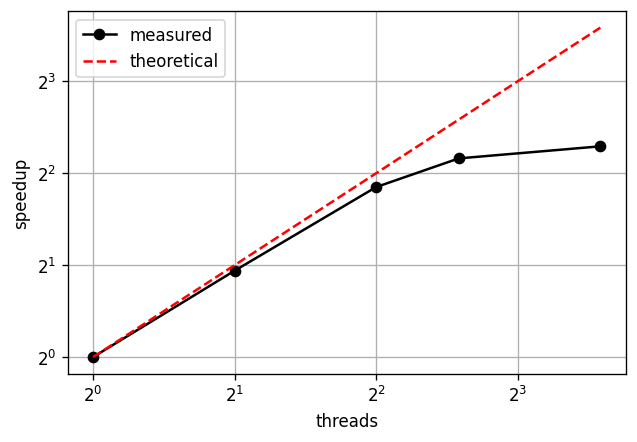

In [28]:
cpus = [1, 2, 4, 6, 12]
wall_time = time1/np.array([time1, time2, time4, time6, time12])

fig, ax = plt.subplots(dpi=120)

plt.plot(cpus, wall_time, 'ko-', label='measured')
plt.plot(cpus, cpus, 'r--', label='theoretical')

ax.set_xlabel('threads')
ax.set_ylabel('speedup')
ax.legend()
ax.grid()
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
plt.show()

## Bayesian Search

In [10]:
def build(**parameters):
    """Build the emulator.
    
    Args:
        lr (float): learning ratio
        second_layer (bool): second recurrent layer
        loss (tensorflow.keras.losses): keras loss function
        ...
        
    Returns:
        tensorflow.keras.Model: a compiled Tensorflow model
    """
    ...  # TODO: Build the emulator.
    

def train(model, data_path, **parameters):
    """Train the emulator.
    
    Args:
        model (tensorflow.keras.losses): a compiled model
        data_path (str): training data path
        ...
        
    Returns:
        tf.keras.Model: a trained Tensorflow model
    """
    ...  # TODO: Train the emulator

    
def evaluate(model, data_path, **parameters):
    """Evaluate the emulator.
    
    Args:
        model (tensorflow.keras.losses): a trained model
        data_path (str): evaluation data path
        ...
        
    Returns:
        float: a model evaluation score
    """
    ...  # TODO: Evaluate the emulator
    
    # Construct a dummy score
    x = parameters['x']
    y = parameters['y']
    z = parameters['z']

    return -x**2 - (y - 1)**2 + 1 - 0.001*(z - 3)**4  # A dummy score
    

def build_train_evaluate(**parameters):
    """Buid, train and evaluate the model.
    
    Args:
        lr (float): learning ratio
        second_layer (bool): second recurrent layer
        loss (tensorflow.keras.losses): keras loss function
        ...
        
    Returns:
        float: a model evaluation score
    """
    model = build(**parameters)
    model = train(model, 'training_data_path', **parameters)
    score = evaluate(model, 'evaluation_data_path', **parameters)
    
    return score

In [11]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3), 'z': (-5, 5)}

optimizer = BayesianOptimization(
    f=build_train_evaluate,
    pbounds=pbounds,
    random_state=1,
)

In [12]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=50,
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        | -11.23    |  2.834    |  1.322    | -4.999    |
|  2        | -18.02    |  2.605    | -2.119    | -4.077    |
|  3        | -8.605    |  2.373    | -0.9266   | -1.032    |
|  4        | -10.68    |  3.078    | -0.4848   |  1.852    |
|  5        | -9.976    |  2.409    |  2.269    | -4.726    |
|  6        | -3.217    |  2.0      |  0.7103   | -0.3992   |
|  7        | -5.876    |  2.0      |  2.648    | -0.5576   |
|  8        | -15.44    |  4.0      |  1.501    | -0.7219   |
|  9        | -3.257    |  2.0      |  1.459    |  0.3849   |
|  10       | -7.0      |  2.0      |  3.0      |  2.45     |
|  11       | -17.62    |  3.978    |  2.667    |  4.932    |
|  12       | -19.02    |  2.0      | -3.0      |  5.0      |
|  13       | -3.956    |  2.0      |  0.0395   |  0.6018   |
|  14       | -3.028    |  2.0      |  1.16     |  1.779    |
|  15   

## Ray

Learn how to use it. Demonstrate how to use it. Then implement for our example (use demo training set) and run an experiment to test the scalability.

Read
 - https://docs.ray.io/en/master/index.html
 - https://docs.ray.io/en/master/tune/index.html

In [13]:
"""The smallest example."""
import ray
ray.init()

@ray.remote
def f(x):
    return x*x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))  # [0, 1, 4, 9]

2021-06-28 16:42:27,928	INFO services.py:1330 -- View the Ray dashboard at http://127.0.0.1:8265


[0, 1, 4, 9]


In [14]:
"""An optimization example."""
from ray import tune


def build_train_evaluate(x, y, z):
    """Buid, train and evaluate the model.
    
    Args:
        ...
        
    Returns:
        float: a model evaluation score
    """
    return x**2 + (y - 1)**2 + 1 + 0.001*(z - 3)**4  # A dummy score


def training_function(config, checkpoint_dir=None):
    x, y, z = config["x"], config["y"], config["z"]  # Retrive the hyperparameters
    score = build_train_evaluate(x, y, z)
    tune.report(mean_loss=score)


analysis = tune.run(
    training_function,
    config={
        "x": tune.grid_search([0.001, 0.01, 0.1, 0.2, 0]),
        "y": tune.choice([1, 2, 3, 4, 1]),
        "z": tune.uniform(0, 7)
    },
    num_samples=5,
)

print("Best config: ", analysis.get_best_config(metric="mean_loss", mode="min"))

2021-06-28 16:42:29,561	WARNING tune.py:488 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,x,y,z
training_function_801d6_00000,RUNNING,,0.001,3,6.89571
training_function_801d6_00001,PENDING,,0.01,1,4.18311
training_function_801d6_00002,PENDING,,0.1,1,6.73163
training_function_801d6_00003,PENDING,,0.2,1,0.865048
training_function_801d6_00004,PENDING,,0,1,6.44969
training_function_801d6_00005,PENDING,,0.001,2,5.17697
training_function_801d6_00006,PENDING,,0.01,4,6.41945
training_function_801d6_00007,PENDING,,0.1,3,2.5755
training_function_801d6_00008,PENDING,,0.2,4,3.68006
training_function_801d6_00009,PENDING,,0,1,6.81512


Result for training_function_801d6_00001:
  date: 2021-06-28_16-42-30
  done: false
  experiment_id: 528d1f708754437896dc92e19c8fa5d4
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 1.0020593140648897
  neg_mean_loss: -1.0020593140648897
  node_ip: 192.168.86.22
  pid: 103585
  time_since_restore: 0.000179290771484375
  time_this_iter_s: 0.000179290771484375
  time_total_s: 0.000179290771484375
  timestamp: 1624923750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 801d6_00001
  
Result for training_function_801d6_00001:
  date: 2021-06-28_16-42-30
  done: true
  experiment_id: 528d1f708754437896dc92e19c8fa5d4
  experiment_tag: 1_x=0.01,y=1,z=4.1831
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 1.0020593140648897
  neg_mean_loss: -1.0020593140648897
  node_ip: 192.168.86.22
  pid: 103585
  time_since_restore: 0.000179290771484375
  time_this_iter_s: 0.000179290771484375
  time_total_s: 0.000179290771484375
  timestamp: 1624923750
  timesteps_s

Result for training_function_801d6_00008:
  date: 2021-06-28_16-42-30
  done: true
  experiment_id: 06c4454c72014c28b39bc25caeabf164
  experiment_tag: 8_x=0.2,y=4,z=3.6801
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 10.040213895104387
  neg_mean_loss: -10.040213895104387
  node_ip: 192.168.86.22
  pid: 103581
  time_since_restore: 0.009233236312866211
  time_this_iter_s: 0.009233236312866211
  time_total_s: 0.009233236312866211
  timestamp: 1624923750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 801d6_00008
  
Result for training_function_801d6_00023:
  date: 2021-06-28_16-42-31
  done: false
  experiment_id: 3895939cc0994a89bab6bac38d02f04a
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 10.088684929514878
  neg_mean_loss: -10.088684929514878
  node_ip: 192.168.86.22
  pid: 103885
  time_since_restore: 0.00017189979553222656
  time_this_iter_s: 0.00017189979553222656
  time_total_s: 0.00017189979553222656
  timestamp: 1624923751
  timest

Result for training_function_801d6_00016:
  date: 2021-06-28_16-42-31
  done: false
  experiment_id: 9112d23cc3f145f38eefc0e038b8a4f2
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 10.000147659392773
  neg_mean_loss: -10.000147659392773
  node_ip: 192.168.86.22
  pid: 103908
  time_since_restore: 0.0001766681671142578
  time_this_iter_s: 0.0001766681671142578
  time_total_s: 0.0001766681671142578
  timestamp: 1624923751
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 801d6_00016
  
Result for training_function_801d6_00016:
  date: 2021-06-28_16-42-31
  done: true
  experiment_id: 9112d23cc3f145f38eefc0e038b8a4f2
  experiment_tag: 16_x=0.01,y=4,z=3.4672
  hostname: aero
  iterations_since_restore: 1
  mean_loss: 10.000147659392773
  neg_mean_loss: -10.000147659392773
  node_ip: 192.168.86.22
  pid: 103908
  time_since_restore: 0.0001766681671142578
  time_this_iter_s: 0.0001766681671142578
  time_total_s: 0.0001766681671142578
  timestamp: 1624923751
  time

Trial name,status,loc,x,y,z,loss,iter,total time (s),neg_mean_loss
training_function_801d6_00000,TERMINATED,,0.001,3,6.89571,5.23033,1,0.00494885,-5.23033
training_function_801d6_00001,TERMINATED,,0.01,1,4.18311,1.00206,1,0.000179291,-1.00206
training_function_801d6_00002,TERMINATED,,0.1,1,6.73163,1.20391,1,0.00018549,-1.20391
training_function_801d6_00003,TERMINATED,,0.2,1,0.865048,1.06078,1,0.0100858,-1.06078
training_function_801d6_00004,TERMINATED,,0,1,6.44969,1.14162,1,0.00212431,-1.14162
training_function_801d6_00005,TERMINATED,,0.001,2,5.17697,2.02246,1,0.0112388,-2.02246
training_function_801d6_00006,TERMINATED,,0.01,4,6.41945,10.1368,1,0.0151846,-10.1368
training_function_801d6_00007,TERMINATED,,0.1,3,2.5755,5.01003,1,0.000245571,-5.01003
training_function_801d6_00008,TERMINATED,,0.2,4,3.68006,10.0402,1,0.00923324,-10.0402
training_function_801d6_00009,TERMINATED,,0,1,6.81512,1.21185,1,0.0135293,-1.21185


2021-06-28 16:42:32,270	INFO tune.py:543 -- Total run time: 3.02 seconds (2.55 seconds for the tuning loop).


Best config:  {'x': 0, 'y': 1, 'z': 3.491425804370846}


## Other Ideas

 - Rocketsled, https://hackingmaterials.lbl.gov/rocketsled/
 - ...

## GPyOpt

In [37]:
import GPyOpt


def build(*parameters):
    """Build the emulator.
    
    Args:
        lr (float): learning ratio
        ...
        
    Returns:
        tensorflow.keras.Model: a compiled Tensorflow model
    """
    ...  # TODO: Build the emulator.
    

def train(model, data_path, parameters):
    """Train the emulator.
    
    Args:
        model (tensorflow.keras.losses): a compiled model
        data_path (str): training data path
        ...
        
    Returns:
        tf.keras.Model: a trained Tensorflow model
    """
    ...  # TODO: Train the emulator

    
def evaluate(model, data_path, parameters):
    """Evaluate the emulator.
    
    Args:
        model (tensorflow.keras.losses): a trained model
        data_path (str): evaluation data path
        ...
        
    Returns:
        float: a model evaluation score
    """
    ...  # TODO: Evaluate the emulator


def build_train_evaluate(parameters):
    """Buid, train and evaluate the model.
    
    Args:
        lr (float): learning ratio
        ...
        
    Returns:
        float: a model evaluation score
    """
    model = build(parameters)
    model = train(model, 'training_data_path', parameters)
    score = evaluate(model, 'evaluation_data_path', parameters)
    
    # Return a dummy score
    x, y, z = parameters[:,0], parameters[:,1], parameters[:,2]
    return x**2 + (y - 1)**2 + 1 + 0.001*(z - 3)**4

In [38]:
domain = [
    {'name': 'x', 'type': 'continuous', 'domain': (-5, 5)},
    {'name': 'y', 'type': 'continuous', 'domain': (-5, 5)},
    {'name': 'z', 'type': 'continuous', 'domain': (-5, 5)}
]

In [39]:
optimizer = GPyOpt.methods.BayesianOptimization(
    f=build_train_evaluate,  
    domain = domain,               
    acquisition_type = 'EI',
    normalize_Y = True,
    initial_design_numdata = 10,
    evaluator_type = 'local_penalization',
    batch_size = 4,
    num_cores = 4,
    acquisition_jitter = 0
) 

In [40]:
# --- Run the optimization for 10 iterations
max_iter = 10                                        
optimizer.run_optimization(max_iter)

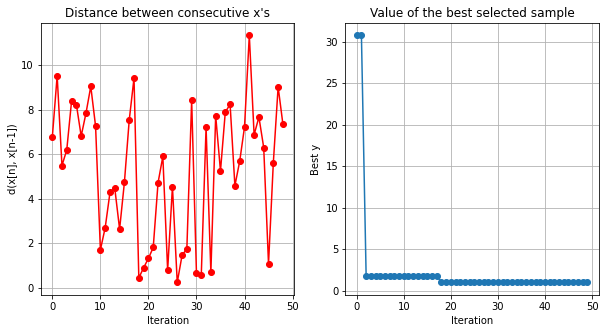

In [41]:
optimizer.plot_convergence()

In [42]:
"""Return the best values."""
optimizer.x_opt

array([-0.03656774,  0.96987932,  3.00036902])